In [7]:
import pandas as pd
mapgenes = pd.read_excel(
    '../raw/map_genes.xlsx'
)
with open('../raw/gene_renames.csv', 'r') as f:
    gene_names = {}
    rest = []
    for line in f:
        line = line.rstrip().split(',')
        gene_names[line[0]] = line[1]
        
        if len(line) > 2:
            rest.extend(line[3:])

mapgenes.loc[:, 'name'] = mapgenes.name.apply(
    lambda x: gene_names[x] if x in gene_names else x
)
remove = [
    'Gcs', 'Pap1', 'Cit1', 'Sdh1-4', 'Cit3'
]
mapgenes = mapgenes.loc[~mapgenes.name.isin(remove), ['name']]
mapgenes = pd.concat(
    [
        mapgenes,
        pd.DataFrame(
            {'name': rest}
        )
    ]
).reset_index(drop = True)
mapnames = {
    v: k for k, v in gene_names.items()
}
mapgenes

,name
0,Slc7a5
1,Apob
2,Lpl
3,Eif2ak4
4,Bcat1
...,...
87,Acadvl
88,Bcat2
89,Idh1
90,Agpat4


In [3]:
proteomics = pd.read_excel(
    '../raw/Proteomics_vulcano_F-test_input_DM.xlsx'
)
proteomics = proteomics.loc[
    ~proteomics['Gene names'].str.startswith('Eif2ak4').isna(),
    :
]
proteomics.rename(
    columns = {
        'Gene names': 'gene_name',
        'F-test: Mean log2(Ratio) - KO_grp1 vs WT': 'lfc',
        'F-test: Moderated -log10(Pvalue)': 'pval'
    },
    inplace = True
)
rows = []
for i, row in proteomics.iterrows():
    names = row.gene_name.split(';')
    for name in names:
        rows.append(
            [name, row['lfc'], row['pval']]
        )

proteomics = pd.DataFrame(
    rows,
    columns = ['gene_name', 'lfc', 'pval']
)
proteomics

,gene_name,lfc,pval
0,Tecpr2,9.002911,1.694369
1,Psmc3,6.656874,0.155194
2,Agt,2.431391,4.533143
3,Sh3d21,2.401648,2.677114
4,C1qb,2.400351,4.938216
...,...,...,...
9612,Btf3,-3.103615,12.313374
9613,Uchl4,-3.152603,12.164777
9614,Nrp1,-2.401969,2.967190
9615,Fcrl1,-2.539066,12.111319


In [4]:
proteomics[proteomics.gene_name == 'Acly']

,gene_name,lfc,pval
6183,Acly,0.090293,0.193541
6403,Acly,-0.272903,1.233274


In [8]:
import numpy as np
mapproteomics = proteomics[proteomics.gene_name.isin(mapgenes.name)].copy()
#mapgenes[~mapgenes.name.isin(mapproteomics.gene_name)]#.to_csv('genes_not_in_proteomics.csv')
mapproteomics = mapproteomics.loc[
    ~np.isinf(mapproteomics.lfc),
    :
]
mapproteomics.loc[:, 'gene_name'] = mapproteomics.gene_name.apply(
    lambda x: f'{x} ({mapnames[x]})' if x in mapnames else x
)
mapproteomics['pval_significance'] = mapproteomics['pval'].apply(
    lambda x: x > -np.log10(0.05)
)
mapproteomics

,gene_name,lfc,pval,pval_significance
25,Ehhadh (Ehhadh (perox)),1.352171,5.020351,True
100,Bckdhb,1.126917,3.208425,True
394,Acsf2,0.687556,2.864780,True
515,Cept1 (Ept1),0.391108,3.346919,True
584,Cpt2,0.818090,3.083622,True
...,...,...,...,...
8548,Chka (Cki1),-0.330586,1.198317,False
8652,Lpl,-0.233349,0.273373,False
8841,Idh1,-0.325396,2.512983,True
9022,Slc7a5,-0.611061,1.564440,True


In [9]:
# needed to replace , with - in names of line 56 and 60 of pos mode
metabolomics = {
    k: pd.read_csv(
        f'../raw/statistical_results_embl_metabolomics_cells_{k}mode_raw.csv',
        sep = ',',
        usecols = range(1,13)
    ) for k in ['pos', 'neg']
}
metabolomics

{'pos':       ID  RT [min]        m/z                Identification Adduct type  \
 0   3526     6.197  282.11969            1-Methyladenosine*      [M+H]+   
 1    843     7.423  104.07063          4-AMINOBUTYRIC ACID*      [M+H]+   
 2   1520     5.893  146.09244      4-Guanidinobutyric acid*      [M+H]+   
 3   1782     3.268  160.13327  5-Aminovaleric acid betaine*      [M+H]+   
 4    817     7.136  103.03898                 ACETOACETATE*      [M+H]+   
 ..   ...       ...        ...                           ...         ...   
 76  2587     5.705  205.09726                    TRYPTOPHAN      [M+H]+   
 77  2149     7.438  182.08122                      TYROSINE      [M+H]+   
 78  1421     1.643  139.05006                Urocanic acid*      [M+H]+   
 79  1422     2.240  139.05009                UROCANIC ACID*      [M+H]+   
 80  1074     6.730  118.08635                        Valine      [M+H]+   
 
     Statistical Value  p-value  adjusted p-value (BH)  fold change KO  vs  WT 

In [11]:
mapmetabolites = pd.read_excel(
    '../raw/map_metabolites.xlsx'
)
mapmetabolites.rename(
    columns = {
        'Name in map': 'map',
        'Name in dataset': 'dataset'
    },
    inplace = True
)
mapmetabolites.loc[mapmetabolites.dataset == 'Butyrylcarnitine', 'dataset'] = 'Butyryl carnitine'
mapmetabolites.loc[mapmetabolites.dataset == 'Butyryl carnitine', 'map'] = 'Butyrylcarnitine'
mapmetabolites.loc[mapmetabolites.dataset == 'Acetylcarnitine', 'map'] = 'Acetylcarnitine'
mapmetabolites

,map,dataset
0,Valine,Valine
1,Leucine,Leucine
2,Isoleucine,Isoleucine
3,Serine,Serine
4,Threonine,Threonine
5,Methionine,Methionine
6,Carnitine,Carnitine
7,alpha-KG,ALPHA-KETOGLUTARIC ACID
8,Asparate,ASPARTIC ACID
9,Glutamate,Glutamic acid


In [12]:
mapmetabolomics = pd.DataFrame()
suffixes = []
for k, df in metabolomics.items():
    suffixes.append(k)
    df = df.loc[
        df.Identification.isin(mapmetabolites.dataset),
        ['Identification', 'fold change KO  vs  WT', 'p-value', 'adjusted p-value (BH)']
    ].rename(
        columns = {
            'Identification': 'dataname',
            'fold change KO  vs  WT': 'lfc',
            'p-value': 'pval', 
            'adjusted p-value (BH)': 'padj'
        }
    )
#    df.loc[:, 'lfc'] = np.log2(df.lfc)
    if mapmetabolomics.empty:
        mapmetabolomics = df
    
    else:
        mapmetabolomics = mapmetabolomics.merge(
            df,
            on = 'dataname',
            how = 'outer',
            suffixes = suffixes
        )

mapmetabolomics['lfc'] = mapmetabolomics.iloc[:, [1, 4]].apply(
    np.nanmean,
    axis = 1
)
mapmetabolomics.loc[:, 'lfc'] = np.log2(mapmetabolomics.lfc)
d = {r[1]: r[0] for i, r in mapmetabolites.iterrows()}
mapmetabolomics['name'] = mapmetabolomics.dataname.apply(
    lambda x: d[x]
)

def map_significance(x):
    sig = True
    for p in x:
        if not np.isnan(p):
            sig = (p < 0.05) & sig
    
    return sig
    
mapmetabolomics['pval_significance'] = mapmetabolomics[['pvalpos', 'pvalneg']].apply(
    map_significance,
    axis = 1
)
mapmetabolomics['padj_significance'] = mapmetabolomics[['padjpos', 'padjneg']].apply(
    map_significance,
    axis = 1
)
mapmetabolomics

,dataname,lfcpos,pvalpos,padjpos,lfcneg,pvalneg,padjneg,lfc,name,pval_significance,padj_significance
0,ACETOACETATE*,0.5837,0.01234,0.09778,NaN,NaN,NaN,-0.776701,Acetoacetate,True,False
1,Acetylcarnitine,0.6318,0.00700,0.09448,NaN,NaN,NaN,-0.662460,Acetylcarnitine,True,False
2,Butyryl carnitine,0.5394,0.00556,0.09448,NaN,NaN,NaN,-0.890573,Butyrylcarnitine,True,False
3,Carnitine,0.5817,0.01135,0.09778,NaN,NaN,NaN,-0.781653,Carnitine,True,False
4,Choline,0.8398,0.09471,0.19548,NaN,NaN,NaN,-0.251882,Choline,False,False
5,Glutamic acid,0.6470,0.03466,0.16517,0.7989,0.04785,0.20802,-0.468032,Glutamate,True,False
6,Isoleucine,0.7692,0.04128,0.16717,0.8218,0.20657,0.42516,-0.330066,Isoleucine,False,False
7,Leucine,0.7406,0.03980,0.16717,0.7564,0.08606,0.24646,-0.417926,Leucine,False,False
8,Methionine,0.8546,0.31380,0.40996,0.9660,0.82345,0.92638,-0.135586,Methionine,False,False
9,Phosphocholine,0.4223,0.01328,0.09778,NaN,NaN,NaN,-1.243660,P-Choline,True,False


In [13]:
cells_pos = pd.read_csv(
    '../raw/lipidomics_rawdata_dissociated_cells_posmode.txt',
    sep = '\t',
    skiprows = 4
)
cells_neg = pd.read_csv(
    '../raw/lipidomics_rawdata_dissociated_cells_negmode.txt',
    sep = '\t',
    skiprows = 4
)
cells_pos['KOstd'] = np.log2(cells_pos[['Cell_KO_1A', 'Cell_KO_1B', 'Cell_KO_2A', 'Cell_KO_3B', 'Cell_KO_4A']]).std(axis = 1)
cells_pos['WTstd'] = np.log2(cells_pos[['Cell_WT_1A', 'Cell_WT_1B', 'Cell_WT_2A', 'Cell_WT_3B', 'Cell_WT_4A']]).std(axis = 1)
cells_neg['KOstd'] = np.log2(cells_neg[['Cell_KO_1A', 'Cell_KO_1B', 'Cell_KO_2A', 'Cell_KO_3B', 'Cell_KO_4A']]).std(axis = 1)
cells_neg['WTstd'] = np.log2(cells_neg[['Cell_WT_1A', 'Cell_WT_1B', 'Cell_WT_2A', 'Cell_WT_3B', 'Cell_WT_4A']]).std(axis = 1)
filter_names = cells_pos[(cells_pos[['KOstd', 'WTstd']] > 1).any(axis = 1) | cells_pos[['KOstd', 'WTstd']].isna().any(axis = 1)]['Metabolite name'].to_list()
filter_names.extend(
    cells_neg[(cells_neg[['KOstd', 'WTstd']] > 1).any(axis = 1) | cells_neg[['KOstd', 'WTstd']].isna().any(axis = 1)]['Metabolite name'].to_list()
)
filter_names

/Users/dmalzl/miniconda3/envs/mathcode/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
/Users/dmalzl/miniconda3/envs/mathcode/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
/Users/dmalzl/miniconda3/envs/mathcode/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
/Users/dmalzl/miniconda3/envs/mathcode/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


['CE 22:4',
 'CE 22:6',
 'CE 24:4',
 'DG 34:2',
 'DG 34:2|DG 16:0_18:2',
 'DG 36:3|DG 18:1_18:2',
 'DG 36:4',
 'DG 36:5|DG 18:2_18:3',
 'DGCC 36:2',
 'DGDG 34:2|DGDG 16:0_18:2',
 'DGDG 36:3|DGDG 18:1_18:2',
 'DGDG 36:4|DGDG 18:2_18:2',
 'HexCer 34:0;4O|HexCer 18:0;3O/16:0;(2OH)',
 'LPC 18:3/0:0',
 'MGDG 36:4|MGDG 18:2_18:2',
 'TG 24:0|TG 8:0_8:0_8:0',
 'TG 28:0|TG 8:0_10:0_10:0',
 'TG 32:0|TG 8:0_8:0_16:0',
 'TG 34:0|TG 8:0_10:0_16:0',
 'TG 36:0|TG 10:0_10:0_16:0',
 'TG 42:2|TG 8:0_16:0_18:2',
 'TG 44:2|TG 12:0_14:0_18:2',
 'TG 44:3|TG 8:0_18:1_18:2',
 'TG 50:2;1O|TG 16:0_18:2_16:0;1O',
 'TG 51:3|TG 15:0_18:1_18:2',
 'TG 52:3|TG 16:0_18:1_18:2',
 'TG 52:3|TG 16:0_18:1_18:2',
 'TG 52:4;1O|TG 16:0_18:2_18:2;1O',
 'TG 52:4|TG 16:0_18:1_18:3',
 'TG 52:4|TG 16:0_18:2_18:2',
 'TG 52:5;1O|TG 18:2_18:2_16:1;1O',
 'TG 53:2|TG 17:0_17:1_19:1',
 'TG 53:3|TG 17:0_18:1_18:2',
 'TG 53:4|TG 17:1_18:1_18:2',
 'TG 54:2|TG 16:0_18:1_20:1',
 'TG 54:2|TG 18:0_18:1_18:1',
 'TG 54:3;1O|TG 18:1_18:1_18:1;1O'

In [14]:
whole_tissue_files = {
    'neg': '../raw/statistical_results_KO_vs_WT_wholetissue_negmode_new_normalizedTIC_outlierremoved.xlsx',
    'pos': '../raw/statistical_results_KO_vs_WT_wholetissue_posmode_new_normalizedTIC_outlierremoved.xlsx'
}
whole_tissue_lipidomics = {}
for k, filename in whole_tissue_files.items():
    df = pd.read_excel(
        filename, 
        usecols = range(1,13)
    )
    df = df.loc[~df.Identification.isin(filter_names)]
    df['name'] = df.Identification.apply(
        lambda x: x.split()[0]
    )
    whole_tissue_lipidomics[k] = df
whole_tissue_lipidomics

{'neg':        ID  RT [min]        m/z                      Identification  \
 0    2568     8.923  734.49585                PS 32:0|PS 16:0_16:0   
 1    2937     9.573  763.59521                          SM 34:0;2O   
 2    3274     8.988  788.54285                PC 32:2|PC 16:0_16:2   
 3    2294     7.838  706.46484                PS 30:0|PS 14:0_16:0   
 4    4650    13.748  870.70251  HexCer 42:1;2O|HexCer 18:1;2O/24:0   
 ..    ...       ...        ...                                 ...   
 437  3502     9.949  589.55463               IS: Ceramide C15 (d7)   
 438  2528    11.249  730.53931                PE 35:1|PE 17:0_18:1   
 439  4894     8.359  886.54694          PS 40:4;3O|PS 22:4_18:0;3O   
 440  5555    13.649  928.70337                PC 42:2|PC 24:0_18:2   
 441  3357    11.188  792.55444                PE 40:5|PE 18:0_22:5   
 
      Adduct type  Statistical Value  p-value  adjusted p-value (BH)  \
 0         [M-H]-              -8.28  0.00043                0.0880

In [15]:
files = {
    'pos': '../raw/statistical_results_KO_vs_WT_dissociatedcells_lipidomics_posmode.xlsx',
    'neg': '../raw/statistical_results_KO_vs_WT_dissociatedcells_lipidomics_negmode.xlsx'
}
lipidomics = {}
for k, filename in files.items():
    df = pd.read_excel(
        filename, 
        usecols = range(1,13)
    )
    df = df.loc[~df.Identification.isin(filter_names)]
    df['name'] = df.Identification.apply(
        lambda x: x.split()[0]
    )
    lipidomics[k] = df
lipidomics

{'pos':         ID  RT [min]        m/z                 Identification Adduct type  \
 0    48745     9.958  911.56274                        PI 38:3     [M+Na]+   
 1    48273     9.957  906.60699                        PI 38:3    [M+NH4]+   
 2    33669     9.643  738.50342                        PE 34:2     [M+Na]+   
 3    40216    12.244  820.58093                        PE 40:3     [M+Na]+   
 4    48452     8.607  908.53943                        PS 44:9     [M+Na]+   
 ..     ...       ...        ...                            ...         ...   
 538  18276     2.766  448.34247                       CAR 20:4      [M+H]+   
 539  37007    16.996  782.72437      TG 45:0|TG 14:0_15:0_16:0    [M+NH4]+   
 540  43883    11.167  860.61163                        PC 40:4     [M+Na]+   
 541  29049    14.910  652.66125   Cer 42:0;2O|Cer 18:0;2O/24:0      [M+H]+   
 542  48938    17.562  913.75977  TG O-56:7|TG O-20:5_18:1_18:1     [M+Na]+   
 
      Statistical Value  p-value  adjusted 

In [16]:
lipidomics['pos'].Identification.unique()

array(['PI 38:3', 'PE 34:2', 'PE 40:3', 'PS 44:9', 'PE 38:6', 'PE 38:5',
       'PS 40:5', 'PE 32:2|PE 16:0_16:2', 'PC 32:2|PC 16:0_16:2',
       'PE 38:2', 'PE 42:5|PE 18:0_24:5', 'PE 34:2|PE 16:1_18:1',
       'PE P-42:6|PE P-18:1_24:5', 'PC 30:2|PC 14:0_16:2', 'PC 36:2',
       'PE 38:1', 'PE 42:5', 'PC 36:3|PC 16:0_20:3', 'PE 36:5', 'PC 38:4',
       'PC 30:2', 'PC 34:2|PC 16:1_18:1', 'PE P-40:6|PE P-18:1_22:5',
       'PE 36:1|PE 18:0_18:1', 'PE 34:1|PE 16:0_18:1',
       'PE 32:1|PE 14:0_18:1', 'PC 36:2|PC 18:1_18:1', 'PE 34:1',
       'PS 42:4', 'PE 42:4', 'PE P-38:3|PE P-18:0_20:3',
       'CL 66:4|CL 32:2_34:2', 'PE 40:5', 'PE 36:2|PE 18:1_18:1',
       'CL 68:4|CL 32:2_36:2', 'PE 40:5|PE 16:0_24:5', 'PE 44:9',
       'PC 30:1', 'PE 36:4', 'PE 36:1', 'PE 32:1', 'CAR 5:0', 'PE 36:2',
       'PI 38:5', 'PE P-40:5|PE P-16:0_24:5', 'CL 64:4|CL 32:2_32:2',
       'PE P-34:1|PE P-16:0_18:1', 'PE 34:0|PE 16:0_18:0',
       'CL 66:3|CL 32:1_34:2', 'PE 34:4', 'PC 40:6|PC 18:1_22:5',
  

In [17]:
maplipids = pd.read_excel(
    '../raw/map_lipids.xlsx'
)
maplipids.rename(
    columns = {
        'Name in map': 'map',
        'Name in Data': 'dataset'
    },
    inplace = True
)
maplipids = maplipids.loc[~(maplipids.map == 'PtdCho'), :]
maplipids

,map,dataset
0,PI,PI
1,PS,PS
2,PE,PE
3,PC,PC
4,CL,CL
5,FAs,FA
6,Phosphatidic acid,PA
7,Cholesterol,Cholesterol
8,Ceramide,Cer
9,Sphingomyelin,SM


In [18]:
whole_tissue_maplipidomics = pd.DataFrame()
for k, df in whole_tissue_lipidomics.items():
    df = df.loc[
        df.name.isin(maplipids.dataset),
        ['name', 'fold change KO  vs  WT', 'p-value']
    ].rename(
        columns = {
            'name': 'dataset',
            'fold change KO  vs  WT': 'foldchange'
        }
    )
    df['logpval'] = -np.log10(df['p-value'])
    data = []
    for name, group in df.groupby('dataset'):
        data.append(
            [
                name,
                np.average(
                    group['foldchange'],
                    weights = group['logpval']
                )
            ]
        )
    
    df = pd.DataFrame(
        data,
        columns = ['dataset', 'foldchange']
    )
    if whole_tissue_maplipidomics.empty:
        whole_tissue_maplipidomics = df
    
    else:
        whole_tissue_maplipidomics = whole_tissue_maplipidomics.merge(
            df,
            on = 'dataset',
            how = 'outer'
        )

whole_tissue_maplipidomics['lfc'] = whole_tissue_maplipidomics.iloc[:, [1, 2]].apply(
    np.nanmean,
    axis = 1
)
whole_tissue_maplipidomics.loc[:, 'lfc'] = np.log2(whole_tissue_maplipidomics.lfc)
d = {r[1]: r[0] for i, r in maplipids.iterrows()}
whole_tissue_maplipidomics['name'] = whole_tissue_maplipidomics.dataset.apply(
    lambda x: d[x]
)
whole_tissue_maplipidomics

,dataset,foldchange_x,foldchange_y,lfc,name
0,CL,0.916371,0.923254,-0.120589,CL
1,Cer,1.019609,1.090227,0.077131,Ceramide
2,FA,0.998680,NaN,-0.001906,FAs
3,PA,0.722759,NaN,-0.468414,Phosphatidic acid
4,PC,1.000050,0.965810,-0.024839,PC
5,PE,0.899051,0.891391,-0.159684,PE
6,PI,0.882383,0.894621,-0.170553,PI
7,PS,0.855221,0.887602,-0.198574,PS
8,SM,1.313029,1.275138,0.371931,Sphingomyelin
9,DG,NaN,1.136321,0.184371,Diacylglycerol


In [19]:
# this needs to be refactored
# do weighted average for each dataset and then combine
# see how it looks compared to first combine and then average
# merge will likely fail if used like now due to many to many mapping
# maybe use Idenfitication for mergeing?
maplipidomics = pd.DataFrame()
for k, df in lipidomics.items():
    df = df.loc[
        df.name.isin(maplipids.dataset),
        ['name', 'fold change KO  vs  WT', 'p-value']
    ].rename(
        columns = {
            'name': 'dataset',
            'fold change KO  vs  WT': 'foldchange'
        }
    )
    df['logpval'] = -np.log10(df['p-value'])
    data = []
    for name, group in df.groupby('dataset'):
        data.append(
            [
                name,
                np.average(
                    group['foldchange'],
                    weights = group['logpval']
                )
            ]
        )
    
    df = pd.DataFrame(
        data,
        columns = ['dataset', 'foldchange']
    )
    if maplipidomics.empty:
        maplipidomics = df
    
    else:
        maplipidomics = maplipidomics.merge(
            df,
            on = 'dataset',
            how = 'outer'
        )

maplipidomics['lfc'] = maplipidomics.iloc[:, [1, 2]].apply(
    np.nanmean,
    axis = 1
)
maplipidomics.loc[:, 'lfc'] = np.log2(maplipidomics.lfc)
d = {r[1]: r[0] for i, r in maplipids.iterrows()}
maplipidomics['name'] = maplipidomics.dataset.apply(
    lambda x: d[x]
)
maplipidomics

,dataset,foldchange_x,foldchange_y,lfc,name
0,CL,0.696634,0.718660,-0.498898,CL
1,Cer,0.732083,0.675056,-0.507235,Ceramide
2,DG,0.749948,NaN,-0.415137,Diacylglycerol
3,PC,0.742101,0.737697,-0.434600,PC
4,PE,0.674857,0.659319,-0.584050,PE
5,PI,0.715003,0.669162,-0.530984,PI
6,PS,0.668283,0.623448,-0.630694,PS
7,SM,0.728166,0.749093,-0.437078,Sphingomyelin
8,TG,0.944346,NaN,-0.082613,Triacylglycerol
9,FA,NaN,0.859227,-0.218889,FAs


In [20]:
targeted = {}
tmp = pd.read_excel(
    '../raw/targeted_metabolomics.xlsx',
    skiprows = 3,
    index_col = 0,
    nrows = 15
)
tmp.drop(
    columns = tmp.columns[tmp.columns.str.startswith('Unnamed')],
    inplace = True
)
tmp = tmp.loc[
    ~tmp.isna().all(axis = 1),
    :
]
targeted['hilic'] = tmp

tmp = pd.read_excel(
    '../raw/targeted_metabolomics.xlsx',
    skiprows = 21,
    index_col = 0,
    nrows = 15
)
tmp.drop(
    columns = tmp.columns[tmp.columns.str.startswith('Unnamed')],
    inplace = True
)
tmp = tmp.loc[
    ~tmp.isna().all(axis = 1),
    :
]
targeted['rp'] = tmp
targeted

{'hilic':           Pyruvate   Lactate     Taurine  Ketoleucine  Alphaketoglutarate  \
 WT2-1509    2350.0   49880.5  10601502.5       1883.0             58284.5   
 WT2-1609    1998.5   51346.5  10187101.5       1207.5             55196.0   
 WT3-1509    2031.5   74883.5  11161713.0       2006.5             59578.5   
 WT4-2409    2483.0   60476.0  10619331.0        938.0             45911.0   
 WT5-2409    3039.0   67362.0  11414188.0       2254.0             57578.0   
 WT7-2409    2689.0  101985.5  12054538.0       2103.5             82314.5   
 WT9-2409    1823.0  110397.0  13718984.0       1885.0             85441.0   
 KO1-1509    2579.5   48493.5   7011887.0        272.0             40569.5   
 KO2-1509    2284.0   36073.0   6375952.0        493.0             35943.0   
 KO2-1609    2398.0   42871.0   8128643.0        342.0             45657.0   
 KO4-2409    2604.5   43739.0   9014105.0       1427.5             45305.0   
 KO5-2409    2979.0   42386.0   8095330.0        996.0 

In [21]:
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.stats.weightstats import ttest_ind

def normalize_total(df):
    df = df.T
    for c in df.columns:
        df.loc[:, c] = df[c]/df[c].sum() * 1e6
    
    return df.T

def compute_mean(df):
    df = df.copy()
    df['gtype'] = [i[:2] for i in df.index]
    df = df.groupby('gtype').mean()
    df.index = df.index.to_list()
    return df.T

def no_normalization(df):
    return compute_p_df(df)

def ttest(x):
    _, pval, _ = ttest_ind(
        x[x.index.str.startswith('KO')],
        x[x.index.str.startswith('WT')]
    )
    return pval

def compute_p_df(df):
    pvals = df.apply(
        ttest,
        axis = 0
    )
    _, padj = fdrcorrection(
        pvals
    )
    mean_df = compute_mean(df)
    df = pd.DataFrame(
        {
            'fc': mean_df['KO']/mean_df['WT'],
            'pval': pvals,
            'padj': padj
        }
    )
    return df

def standard_normalization(df):
    df = normalize_total(df)
    return compute_p_df(df)

def probabilistic_quotient_normalization(df):
    # performs probabilistic quotient normalization based on median spectrum of the control samples
    # for details see also https://doi.org/10.1021/ac051632c
    df = normalize_total(df)
    reference = df.loc[df.index.str.startswith('WT'), :].median(axis = 0)
    norm_factors =  df.divide(reference).median(axis = 1)
    df = df.divide(norm_factors, axis = 0)
    return compute_p_df(df)

tested = {}
for k, df in targeted.items():
    lfcs = {}
    for norm, func in zip(
        ['no_norm', 'standard_norm', 'pqn_norm'],
        [no_normalization, standard_normalization, probabilistic_quotient_normalization]
    ):
        lfcs[norm] = func(df)
    
    tested[k] = lfcs
    
tested

{'hilic': {'no_norm':                           fc      pval      padj
  Pyruvate            1.035823  0.697896  0.697896
  Lactate             0.772569  0.226120  0.293894
  Taurine             0.710748  0.000159  0.002861
  Ketoleucine         0.555854  0.032163  0.096488
  Alphaketoglutarate  0.770436  0.048479  0.124661
  AMP                 0.572529  0.012834  0.057753
  IMP                 0.889539  0.674952  0.697896
  ADP                 0.734213  0.062948  0.141633
  ATP                 0.799435  0.332505  0.399006
  NAD                 0.793891  0.026601  0.095764
  NADH                0.824437  0.228584  0.293894
  NADP                0.746388  0.142920  0.257256
  NADPH               0.801486  0.108266  0.216532
  CoA                 0.741853  0.161667  0.264546
  Acetyl -CoA         0.803095  0.216333  0.293894
  Glutathione RED     0.727291  0.001724  0.015512
  Glutathione OX      0.700749  0.522782  0.588129
  SAM                 0.812835  0.010164  0.057753,
  'standar

In [22]:
targeted = tested['hilic']['pqn_norm'].merge(
    tested['rp']['pqn_norm'],
    left_index = True,
    right_index = True,
    how = 'outer',
    suffixes = ['hilic', 'rp']
)
targeted['lfc'] = np.log2(np.nanmean(targeted[['fchilic', 'fcrp']], axis = 1))
targeted.reset_index(
    inplace = True
)
targeted.rename(
    columns = {'index': 'name'},
    inplace = True
)
targeted

,name,fchilic,pvalhilic,padjhilic,fcrp,pvalrp,padjrp,lfc
0,ADP,0.981980,0.879489,0.989425,NaN,NaN,NaN,-0.026234
1,AMP,0.749906,0.110818,0.641283,NaN,NaN,NaN,-0.415218
2,ATP,1.098727,0.615482,0.923223,NaN,NaN,NaN,0.135832
3,Acetyl -CoA,1.057958,0.608598,0.923223,NaN,NaN,NaN,0.081282
4,Alanine & Sarcosine,NaN,NaN,NaN,0.939003,4.475508e-01,0.486468,-0.090799
5,Alphaketoglutarate,1.020980,0.722186,0.975009,NaN,NaN,NaN,0.029954
6,Arginine,NaN,NaN,NaN,0.938219,3.580358e-01,0.426233,-0.092004
7,Asparagine,NaN,NaN,NaN,1.100542,8.953518e-02,0.186532,0.138215
8,AsparticAcid,NaN,NaN,NaN,0.910545,2.647272e-01,0.330909,-0.135198
9,Citrulline,NaN,NaN,NaN,1.945443,1.394115e-03,0.005407,0.960099


In [23]:
def map_significance(x):
    sig = True
    for p in x:
        if not np.isnan(p):
            sig = (p < 0.05) & sig
    
    return sig
    
targeted['pval_significance'] = targeted[['pvalhilic', 'pvalrp']].apply(
    map_significance,
    axis = 1
)
targeted['padj_significance'] = targeted[['padjhilic', 'padjrp']].apply(
    map_significance,
    axis = 1
)
targeted

,name,fchilic,pvalhilic,padjhilic,fcrp,pvalrp,padjrp,lfc,pval_significance,padj_significance
0,ADP,0.981980,0.879489,0.989425,NaN,NaN,NaN,-0.026234,False,False
1,AMP,0.749906,0.110818,0.641283,NaN,NaN,NaN,-0.415218,False,False
2,ATP,1.098727,0.615482,0.923223,NaN,NaN,NaN,0.135832,False,False
3,Acetyl -CoA,1.057958,0.608598,0.923223,NaN,NaN,NaN,0.081282,False,False
4,Alanine & Sarcosine,NaN,NaN,NaN,0.939003,4.475508e-01,0.486468,-0.090799,False,False
5,Alphaketoglutarate,1.020980,0.722186,0.975009,NaN,NaN,NaN,0.029954,False,False
6,Arginine,NaN,NaN,NaN,0.938219,3.580358e-01,0.426233,-0.092004,False,False
7,Asparagine,NaN,NaN,NaN,1.100542,8.953518e-02,0.186532,0.138215,False,False
8,AsparticAcid,NaN,NaN,NaN,0.910545,2.647272e-01,0.330909,-0.135198,False,False
9,Citrulline,NaN,NaN,NaN,1.945443,1.394115e-03,0.005407,0.960099,True,True


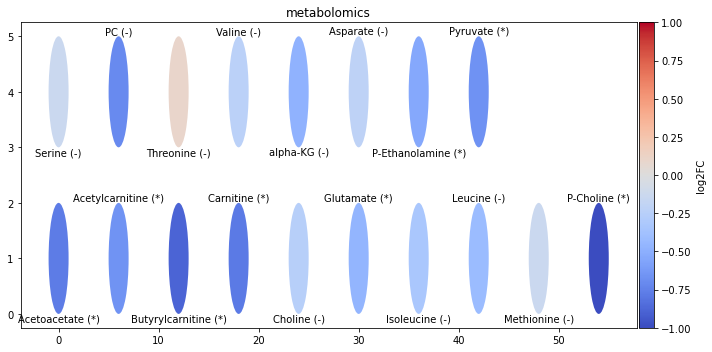

In [25]:
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib as mpl
from matplotlib.patches import Circle, Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams['pdf.fonttype'] = 42


def circler(x, y, **kwargs):
    r = 1
    c = Circle(
        (x, y + r),
        radius = r,
        **kwargs
    )
    return c, y + 2*r, y


def rectangler(x, y, **kwargs):
    a = 2
    r = Rectangle(
        (x - a/2, y),
        a, a,
        **kwargs
    )
    return r, y + a, y


def plot_lfcs(
    data,
    name,
    lfc,
    patcher,
    cmap,
    vmin = None,
    vmax = None,
    patches_per_row = 15,
    hspace = 1,
    vspace = 1
):
    fig, ax = plt.subplots()
    x, y = 0, 0
    vmin = data[lfc].min() if not vmin else vmin
    vmax = data[lfc].max() if not vmax else vmax
    norm = clr.Normalize(vmin, vmax)
    for i, (_, row) in enumerate(data.iterrows()):
        patch, up_edge, low_edge = patcher(
            x, y,
            fc = cmap(norm(row[lfc])),
            ec = None
        )
        ax.add_patch(patch)
        if 'pval_significance' in row:
            text = '{name} ({sig})'.format(
                name = row[name],
                sig = '*' if row['pval_significance'] else '-'
            )
            
        else:
            text = '{name} (-)'.format(
                name = row[name]
            )
            
        ax.text(
            x, 
            up_edge if i%2 else low_edge, 
            text,
            ha = 'center',
            va = 'bottom' if i%2 else 'top'
        )
        width = patch.get_width()
        x = x + width + hspace
        
        if not (i + 1)%patches_per_row:
            y = y + width + vspace
            x = 0
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='2.5%', pad=0.025)
    fig.colorbar(
        mpl.cm.ScalarMappable(
            norm = norm,
            cmap = cmap
        ),
        cax = cax,
        orientation = 'vertical',
        label = 'log2FC'
    )
    ax.autoscale()
    
    return fig, ax
    
    
fig, ax = plot_lfcs(
    mapmetabolomics,
    'name',
    'lfc',
    circler,
    plt.get_cmap('coolwarm'),
    vmin = -1,
    vmax = 1,
    hspace = 4,
    patches_per_row = 10
)
ax.set_title('metabolomics')
fig.set_figwidth(10)
fig.set_figheight(5)
fig.tight_layout()
fig.savefig('../plots/metabolomics_log2FCs.pdf')

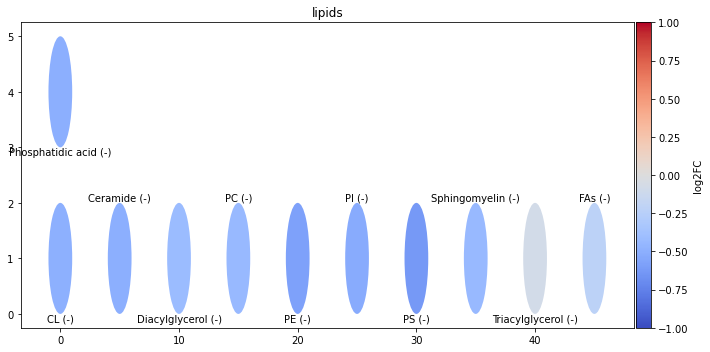

In [26]:
fig, ax = plot_lfcs(
    maplipidomics,
    'name',
    'lfc',
    circler,
    plt.get_cmap('coolwarm'),
    vmin = -1,
    vmax = 1,
    hspace = 3,
    vspace = 1,
    patches_per_row = 10
)
ax.set_title('lipids')
fig.set_figwidth(10)
fig.set_figheight(5)
fig.tight_layout()
fig.savefig('../plots/lipids_log2FCs.pdf')

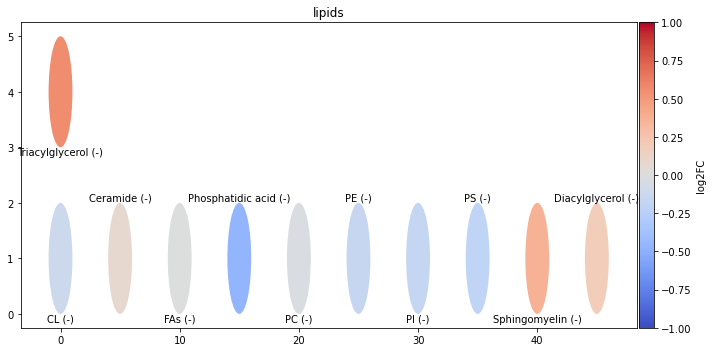

In [27]:
fig, ax = plot_lfcs(
    whole_tissue_maplipidomics,
    'name',
    'lfc',
    circler,
    plt.get_cmap('coolwarm'),
    vmin = -1,
    vmax = 1,
    hspace = 3,
    vspace = 1,
    patches_per_row = 10
)
ax.set_title('lipids')
fig.set_figwidth(10)
fig.set_figheight(5)
fig.tight_layout()
fig.savefig('../plots/whole_tissue_lipids_log2FCs.pdf')

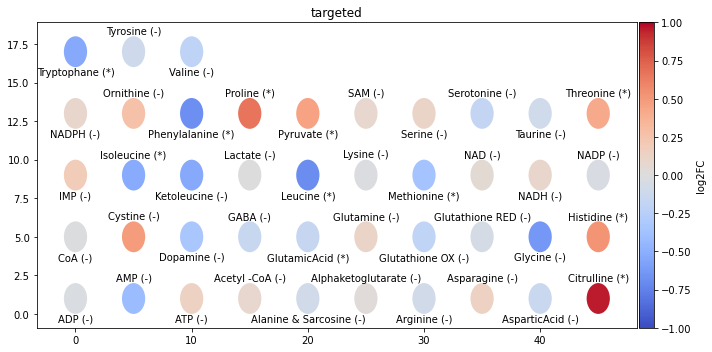

In [28]:
fig, ax = plot_lfcs(
    targeted,
    'name',
    'lfc',
    circler,
    plt.get_cmap('coolwarm'),
    vmin = -1,
    vmax = 1,
    hspace = 3,
    vspace = 2,
    patches_per_row = 10
)
ax.set_title('targeted')
fig.set_figwidth(10)
fig.set_figheight(5)
fig.tight_layout()
fig.savefig('../plots/targeted_log2FCs.pdf')

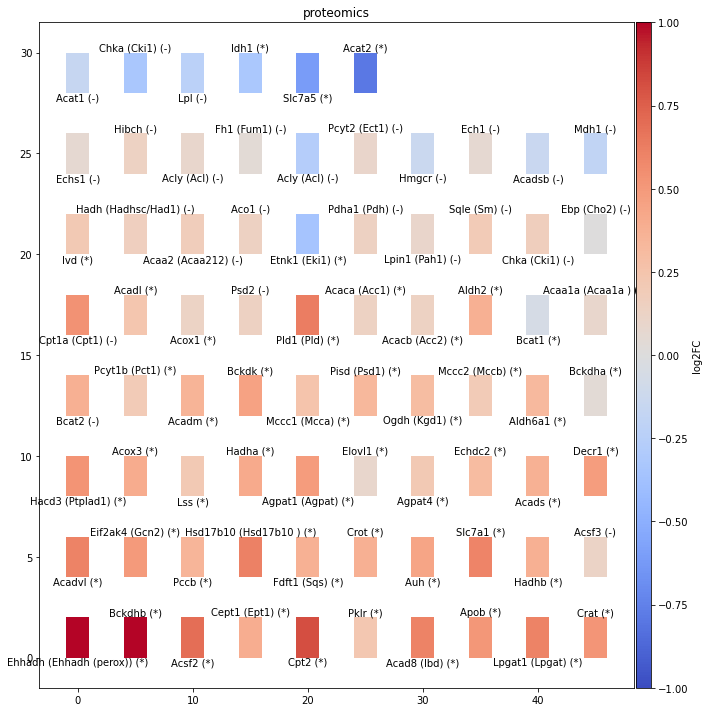

In [29]:
fig, ax = plot_lfcs(
    mapproteomics,
    'gene_name',
    'lfc',
    rectangler,
    plt.get_cmap('coolwarm'),
    vmin = -1,
    vmax = 1,
    hspace = 3,
    vspace = 2,
    patches_per_row = 10
)
ax.set_title('proteomics')
fig.set_figwidth(10)
fig.set_figheight(10)
fig.tight_layout()
fig.savefig('../plots/proteomics_log2FCs.pdf')